In [ ]:
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.init as init
import torch
# Set the default tensor type to double precision (torch.float64)
torch.set_default_dtype(torch.float64)

Make synthetic dataset for linear regression

In [ ]:
def load_synthetic_data_noise(N, P, sigma) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    X = np.random.randn(N, P)
    beta_bar = np.random.randn(P, 1)
    noise = np.random.randn(N, 1)*sigma
    # Y = np.einsum('np,pk->nk',X, beta_bar) + noise
    Y = X@beta_bar + noise
    return X, Y, beta_bar

Make simple linear network with 0 weight initialization

In [ ]:
class linear_model(nn.Module):
  def __init__(self,P):
    super().__init__()
    self.P = P
    self.map = nn.Linear(P, 1, bias=False)
    init.zeros_(self.map.weight)

  def forward(self, X):
    return self.map(X)

**Hyperparameters for the study**

I have chosen them so that the interpolation threshold is at P = 15 and the dataset size varies from 5 to 50.

In [ ]:
config = {
    "learning_rate": 0.01,
    "n_grad_steps": 10000,
    "n_training_data": np.arange(5,50,5),
    "seed": 0,
    "P": 15,
    "sigma": 1,
    "cutoff": 5
}

Generate synthetic data to train a linear map on

In [ ]:
np.random.seed(config["seed"])
X, y, beta_bar = load_synthetic_data_noise(N=200, P=config["P"], sigma=config["sigma"])
# Add trailing dimension to y
if len(y.shape) == 1:
    y = y.reshape(-1, 1)


Train a linear regression model on varying amounts of training data to see double descent

Text(0, 0.5, 'Train Loss')

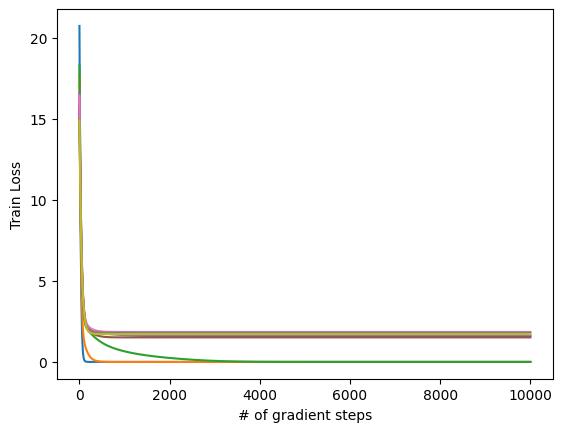

In [ ]:
train_sizes = config["n_training_data"] / X.shape[0]

train_losses = np.zeros((len(train_sizes), config["n_grad_steps"]))
test_losses = np.zeros((len(train_sizes), config["n_grad_steps"]))


for i in range(0,len(train_sizes)):

  train_size = train_sizes[i]

  X_train, X_test, y_train, y_test = train_test_split(
      X, y, train_size=train_size, random_state=config["seed"]
  )

  X_train = torch.tensor(X_train).double()
  y_train = torch.tensor(y_train).double()
  X_test = torch.tensor(X_test).double()
  y_test = torch.tensor(y_test).double()


  network = linear_model(config["P"])
  optimizer = torch.optim.AdamW(params = network.parameters(), lr=config["learning_rate"],betas=(0.9, 0.999), weight_decay=0.00)
  # optimizer = torch.optim.SGD(params = network.parameters(), lr=config["learning_rate"])

  for gradient_step in range(0,config["n_grad_steps"]):

      optimizer.zero_grad()

      activations = network(X_train)
      pred_minus_target = activations - y_train
      loss_train = torch.mean(torch.square(pred_minus_target))

      loss_train.backward()
      optimizer.step()
      train_losses[i, gradient_step] = loss_train.detach().numpy()

      loss_test = torch.mean(torch.square(network.forward(X=X_test) - y_test))
      test_losses[i, gradient_step] = loss_test.detach().numpy()

plt.plot(np.array(train_losses.T));
plt.xlabel('# of gradient steps')
plt.ylabel('Train Loss')

Text(0, 0.5, 'Train loss at end of training')

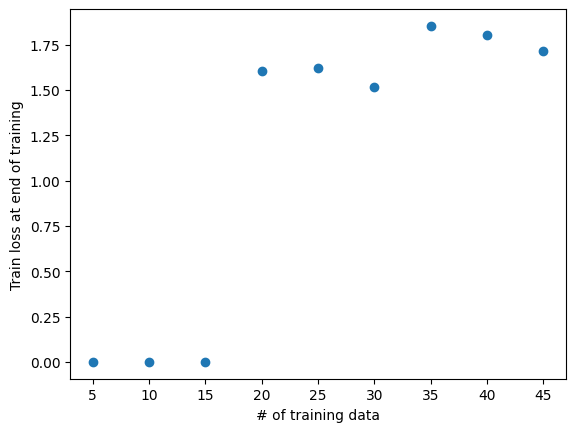

In [ ]:
plt.scatter(config["n_training_data"], train_losses[:,-1])
plt.xlabel("# of training data")
plt.ylabel("Train loss at end of training")

Text(0.5, 1.0, 'Loss as a function of dataset size')

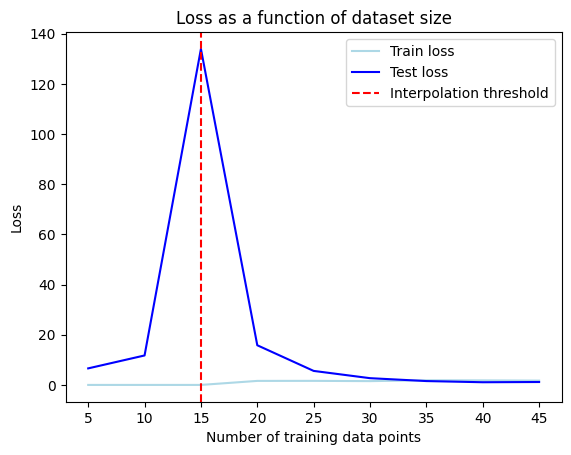

In [ ]:
# Create a figure and axis
fig, ax = plt.subplots()

ax.plot(config['n_training_data'],train_losses[:,-1], label = "Train loss",color = 'lightblue')
ax.plot(config['n_training_data'],test_losses[:,-1], label = "Test loss",color ='blue')


# Plot a vertical line at x = 5
ax.axvline(x=config['P'], color='r', linestyle='--', label = "Interpolation threshold")
ax.legend()
plt.xlabel('Number of training data points')
plt.ylabel('Loss')
plt.title("Loss as a function of dataset size")

Note that in ordinary linear regression, the number of model parameters $P$ must equal the dimensionality $D$ of the features. Consequently, rather than thinking about changing the number of model parameters $P$, we'll instead think about changing the number of data points $N$. Because double descent is fundamentally about the ratio of number of parameters $P$ to number of data points $N$, varying the number of data is as valid as varying the number of parameters.

Consider OLS in the under-parametrized regime:

$$    \hat{\vec{\beta}}_{under} \, = \,  \arg \min_{\vec{\beta}} \frac{1}{N} \sum_n ||\vec{x}_n \cdot \vec{\beta} - y_n||_2^2 \, = \, \arg \min_{\vec{\beta}} ||X \vec{\beta} - Y ||_2^2$$

We can write the closed form solution:
    $$\hat{\vec{\beta}} = (X^T X)^{-1} X^T Y$$

And thus write the predictions of the optimal model:

$$\hat{y}_{test} = \vec{x}_{test} \cdot \hat{\vec{\beta}} = \vec{x}_{test} \cdot (X^T X)^{-1} X^T (Y^{true}_{train} + E) $$

Here $Y^{true}_{train} = \beta^{*}X_{train}$ where $\beta^{*}$ is the true model

Thus we can decompose this as signal + noise:

$$ \hat{y}_{tes} - y_{test}^{true} = \vec{x}_{test} \cdot (X^T X)^{-1} X^T E$$

Doing the SVD of X:
$$ X = U \Sigma V^T $$

We can write the above equation as:

$$    \hat{y}_{test} - y_{test}^* = \vec{x}_{test} \cdot V \Sigma^{+} U^T E = \sum_{r=1}^R  \frac{1}{\sigma_r} (\vec{x}_{test} \cdot \vec{v}_r) (\vec{u}_r \cdot E) $$

Now we can see the contribution of the training data to divergence in the test error as the simultaneous existence of 3 ingredients:

1) How much the training data varies in each direction: The existence of low singular values $\sigma_r$ which appear as $1/\sigma_r$ in the above equation. This happens generically near the interpolation threshold: the \textit{training features} contains small-but-nonzero variance in some singular direction(s). To understand why, here are two explanations:

(a) This behavior is expected according to the Marchenko–Pastur distribution (https://en.wikipedia.org/wiki/Marchenko%E2%80%93Pastur_distribution) which characterizes the distribution of singular values of corresponding term in the pseudo inverse, with random features.
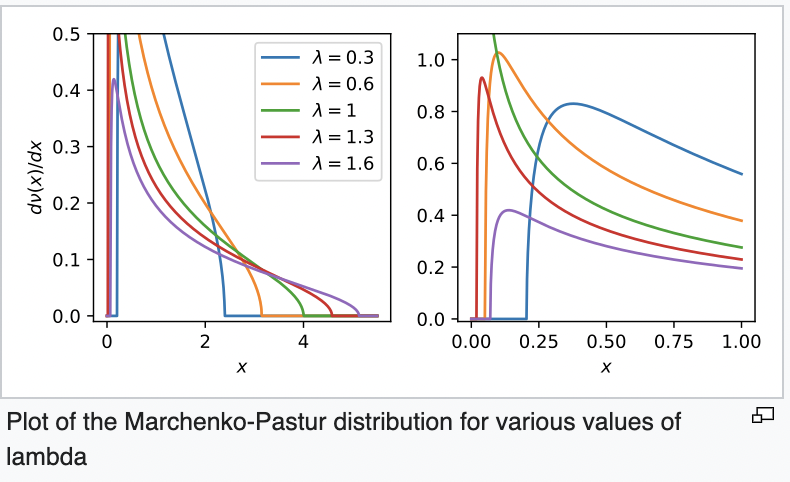

(b) Intuitively, suppose we're given a single data point, this varies in 1 direciton. Adding one more, it will have a small projection along the direction of the first. This means that the training data's smallest non-zero singular value after 2 samples is probabilistically smaller than after 1 sample. As we keep adding more data points, its projections with the previously existing data points will increase and singular values will keep getting lower. At the interpolation threshold, it is likely that new datapoints will be close to being linearly dependent on previous data points, leading to a tiny singular value.

2) The projection of error (the residuals) onto the low left singular value directions $u_r$

3) The variation of test data in the low right singular value directions $v_r$


When a test data point $\vec{x}_{test}$ has a large projection along this low singular value mode, the model is forced to extrapolate significantly beyond what it saw in the training data, in a direction where the training data had an error-prone relationship between its training predictions and the training regression targets, leading to an explosion in test error.


**Bias in the overparametrized regime**

Note that on the left hand side of the plot, the test loss is higher than the train loss, as compared to the right hand side. This is because the model is biased:

In the overparameterized regime, there are more parameters than data; consequently, for N data points in P dimensions, the model can "see" fluctuations in at most P dimensions, but has no "visibility" into the remaining P-N dimensions. This causes information about the optimal linear relationship $\vec{\beta}^*$ to be lost, which increases the overparameterized prediction error $\hat{y}_{test} - y_{test}^*$.

Overparameterized linear regression can do representation learning!

For test datum $\vec{x}_{test}$, the linear model forms an internal representation of the test datum $\hat{\vec{x}}_{test}$ by orthogonally projecting the test datum onto the rowspace via projection matrix $X^T (X X^T)^{-1} X$. The generalization error will then increase commensurate with the inner product between $\hat{\vec{x}}_{test} - \vec{x}_{test}$ and the best fit parameters $\vec{\beta}^*$.

Thus, the model sees the following:

$$\hat{\vec{x}}_{test} = X_{train}^T (X_{train} X_{train}^T)^{-1} X_{train}  \vec{x}_{test}^{true}$$

Thus the bias can be expressed directly and intuitively as:

$$bias = (\hat{\vec{x}}_{test} - \vec{x}_{test}^{true}) \cdot \vec{\beta}^*$$


The full test loss is then given by:
$$\hat{y}_{test,over} - y_{test}^{true} = \vec{x}_{test} \cdot (X_{train}^T (X_{train} X_{train}^T)^{-1} X_{train} - I_D) \beta^* + \sum_{r=1}^R  \frac{1}{\sigma_r} (\vec{x}_{test} \cdot \vec{v}_r) (\vec{u}_r \cdot E)$$

We can now use these insights to make double descent disappear.

First, we verify the existence of small singular values at the interpolation threshold

Text(0, 0.5, 'Smallest singular value')

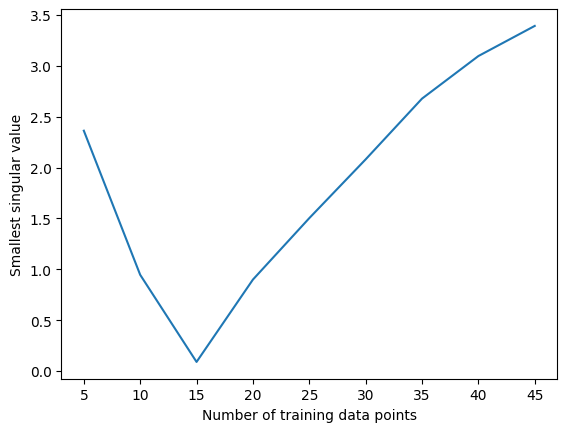

In [ ]:
X, y, beta_bar = load_synthetic_data_noise(P=config["P"], sigma=2*config["sigma"])
# Add trailing dimension to y
if len(y.shape) == 1:
    y = y.reshape(-1, 1)

train_sizes = config["n_training_data"] / X.shape[0]

train_losses = np.zeros((len(train_sizes), config["n_grad_steps"]))
test_losses = np.zeros((len(train_sizes), config["n_grad_steps"]))
min_sing = np.zeros((len(train_sizes)))

for i in range(0,len(train_sizes)):

  train_size = train_sizes[i]

  X_train, X_test, y_train, y_test = train_test_split(
      X, y, train_size=train_size, random_state=config["seed"]
  )
  U, S, Vt = np.linalg.svd(X_train, full_matrices=False, compute_uv=True)
  min_sing[i] = min(S)


plt.plot(config['n_training_data'],min_sing)
plt.xlabel("Number of training data points")
plt.ylabel("Smallest singular value")

Before, we do that a simple prediction is that the size of the error peak at the interpolation threshold should increase linearly with increasing noise. Thus, in the simulation below I double the noise $\sigma$ and the size the peak roughly is 4x, in line with the prediction

Text(0.5, 1.0, 'Loss as a function of dataset size')

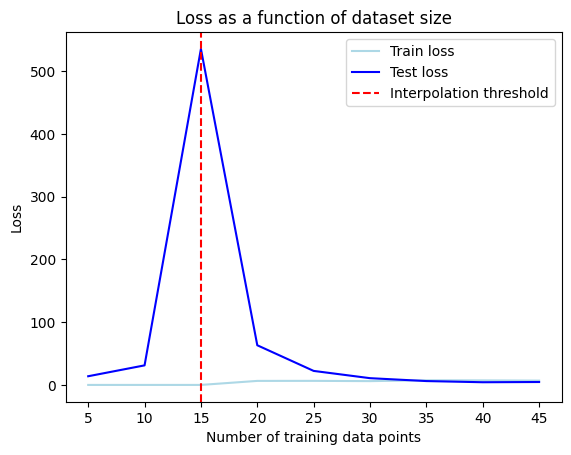

In [ ]:
np.random.seed(config["seed"])
X, y, beta_bar = load_synthetic_data_noise(P=config["P"], sigma=2*config["sigma"])
# Add trailing dimension to y
if len(y.shape) == 1:
    y = y.reshape(-1, 1)

train_sizes = config["n_training_data"] / X.shape[0]

train_losses = np.zeros((len(train_sizes), config["n_grad_steps"]))
test_losses = np.zeros((len(train_sizes), config["n_grad_steps"]))


for i in range(0,len(train_sizes)):

  train_size = train_sizes[i]

  X_train, X_test, y_train, y_test = train_test_split(
      X, y, train_size=train_size, random_state=config["seed"]
  )

  X_train = torch.tensor(X_train).double()
  y_train = torch.tensor(y_train).double()
  X_test = torch.tensor(X_test).double()
  y_test = torch.tensor(y_test).double()


  network = linear_model(config["P"])
  optimizer = torch.optim.AdamW(params = network.parameters(), lr=config["learning_rate"],betas=(0.9, 0.999), weight_decay=0.00)
  # optimizer = torch.optim.SGD(params = network.parameters(), lr=config["learning_rate"])

  for gradient_step in range(0,config["n_grad_steps"]):

      optimizer.zero_grad()

      activations = network(X_train)
      pred_minus_target = activations - y_train
      loss_train = torch.mean(torch.square(pred_minus_target))

      loss_train.backward()
      optimizer.step()
      train_losses[i, gradient_step] = loss_train.detach().numpy()

      loss_test = torch.mean(torch.square(network.forward(X=X_test) - y_test))
      test_losses[i, gradient_step] = loss_test.detach().numpy()

# Create a figure and axis
fig, ax = plt.subplots()

ax.plot(config['n_training_data'],train_losses[:,-1], label = "Train loss",color = 'lightblue')
ax.plot(config['n_training_data'],test_losses[:,-1], label = "Test loss",color ='blue')


# Plot a vertical line at x = 5
ax.axvline(x=config['P'], color='r', linestyle='--', label = "Interpolation threshold")
ax.legend()
plt.xlabel('Number of training data points')
plt.ylabel('Loss')
plt.title("Loss as a function of dataset size")

Text(0, 0.5, 'Train loss at end of training')

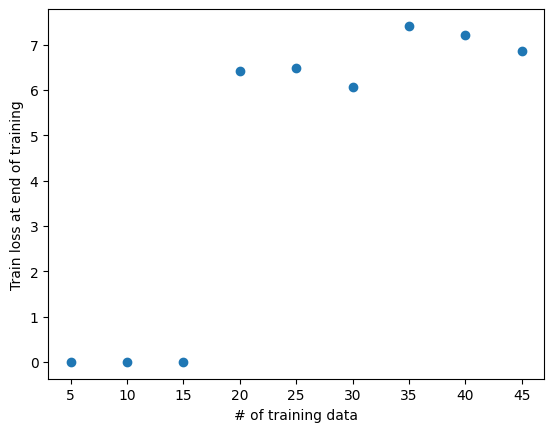

In [ ]:
plt.scatter(config["n_training_data"], train_losses[:,-1])
plt.xlabel("# of training data")
plt.ylabel("Train loss at end of training")

**Method 1 to remove double descent: Removing low singular value directions in the training data**

Low singular value directions are where the effect of noise is most amplified and thus removing them will suppress the effect of noise

Text(0, 0.5, 'Train Loss')

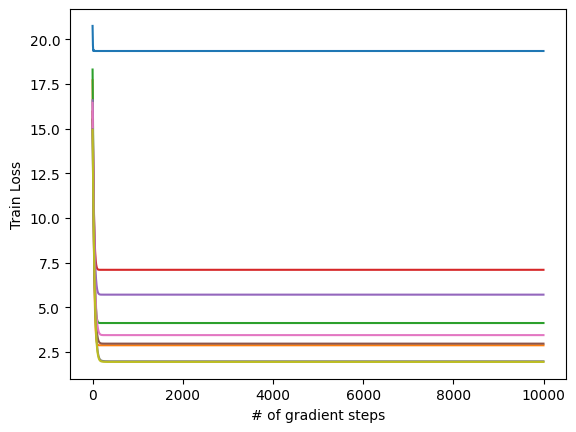

In [ ]:
train_sizes = config["n_training_data"] / X.shape[0]

train_losses_thresholding = np.zeros((len(train_sizes), config["n_grad_steps"]))
test_losses_thresholding = np.zeros((len(train_sizes), config["n_grad_steps"]))


for i in range(0,len(train_sizes)):

  train_size = train_sizes[i]

  X_train, X_test, y_train, y_test = train_test_split(
      X, y, train_size=train_size, random_state=config["seed"]
  )


  U, S, Vt = np.linalg.svd(X_train, full_matrices=False, compute_uv=True)
  S[S<config["cutoff"]] = 0
  X_train = U@np.diag(S)@Vt

  X_train = torch.tensor(X_train).double()
  y_train = torch.tensor(y_train).double()
  X_test = torch.tensor(X_test).double()
  y_test = torch.tensor(y_test).double()


  network = linear_model(config["P"])
  optimizer = torch.optim.AdamW(params = network.parameters(), lr=config["learning_rate"],betas=(0.9, 0.999), weight_decay=0.0)
  # optimizer = torch.optim.SGD(params = network.parameters(), lr=config["learning_rate"])


  for gradient_step in range(0,config["n_grad_steps"]):

      optimizer.zero_grad()

      activations = network(X_train)
      pred_minus_target = activations - y_train
      loss_train = torch.mean(torch.square(pred_minus_target))

      loss_train.backward()
      optimizer.step()
      train_losses_thresholding[i, gradient_step] = loss_train.detach().numpy()

      loss_test = torch.mean(torch.square(network.forward(X=X_test) - y_test))
      test_losses_thresholding[i, gradient_step] = loss_test.detach().numpy()



plt.plot(np.array(train_losses_thresholding.T));
plt.xlabel('# of gradient steps')
plt.ylabel('Train Loss')

Text(0, 0.5, 'Loss')

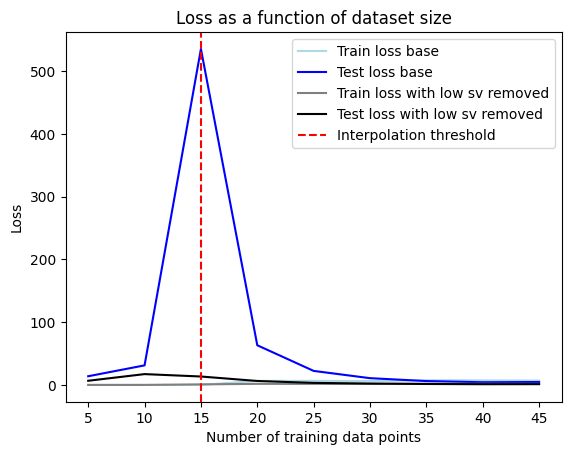

In [ ]:
# Create a figure and axis
fig, ax = plt.subplots()


ax.plot(config['n_training_data'],train_losses[:,-1], label = "Train loss base",color = 'lightblue')
ax.plot(config['n_training_data'],test_losses[:,-1], label = "Test loss base ",color ='blue')

ax.plot(config['n_training_data'],train_losses_thresholding[:,-1], label = "Train loss with low sv removed",color = 'grey')
ax.plot(config['n_training_data'],test_losses_thresholding[:,-1], label = "Test loss with low sv removed",color ='black')


# Plot a vertical line at x = 5
ax.axvline(x=config['P'], color='r', linestyle='--', label = "Interpolation threshold")
ax.legend()
plt.title("Loss as a function of dataset size")
plt.xlabel('Number of training data points')
plt.ylabel('Loss')

**Method 2 to remove double descent: L2 regularization (weight decay)**

L2 regularization effectively increases all singular values and thus there are no low singular value directions to amplify the noise

Here I have used 2 values of weight regularization: 0.1 and 1

0.1 reduces the size of the test loss peak but 1 eliminates it

Text(0, 0.5, 'Train Loss')

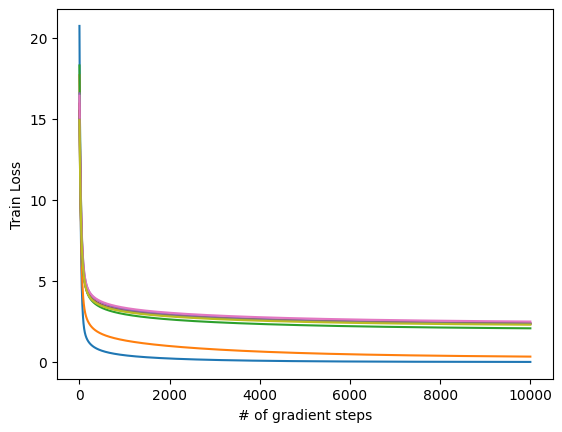

In [ ]:
train_sizes = config["n_training_data"] / X.shape[0]

train_losses_regularization1 = np.zeros((len(train_sizes), config["n_grad_steps"]))
test_losses_regularization1 = np.zeros((len(train_sizes), config["n_grad_steps"]))


for i in range(0,len(train_sizes)):

  train_size = train_sizes[i]

  X_train, X_test, y_train, y_test = train_test_split(
      X, y, train_size=train_size, random_state=config["seed"]
  )

  X_train = torch.tensor(X_train).double()
  y_train = torch.tensor(y_train).double()
  X_test = torch.tensor(X_test).double()
  y_test = torch.tensor(y_test).double()


  network = linear_model(config["P"])
  optimizer = torch.optim.AdamW(params = network.parameters(), lr=config["learning_rate"],betas=(0.9, 0.999), weight_decay=1)
  # optimizer = torch.optim.SGD(params = network.parameters(), lr=config["learning_rate"])


  for gradient_step in range(0,config["n_grad_steps"]):

      optimizer.zero_grad()

      activations = network(X_train)
      pred_minus_target = activations - y_train
      loss_train = torch.mean(torch.square(pred_minus_target))

      loss_train.backward()
      optimizer.step()
      train_losses_regularization1[i, gradient_step] = loss_train.detach().numpy()

      loss_test = torch.mean(torch.square(network.forward(X=X_test) - y_test))
      test_losses_regularization1[i, gradient_step] = loss_test.detach().numpy()



train_sizes = config["n_training_data"] / X.shape[0]

train_losses_regularization2 = np.zeros((len(train_sizes), config["n_grad_steps"]))
test_losses_regularization2 = np.zeros((len(train_sizes), config["n_grad_steps"]))


for i in range(0,len(train_sizes)):

  train_size = train_sizes[i]

  X_train, X_test, y_train, y_test = train_test_split(
      X, y, train_size=train_size, random_state=config["seed"]
  )

  X_train = torch.tensor(X_train).double()
  y_train = torch.tensor(y_train).double()
  X_test = torch.tensor(X_test).double()
  y_test = torch.tensor(y_test).double()


  network = linear_model(config["P"])
  optimizer = torch.optim.AdamW(params = network.parameters(), lr=config["learning_rate"],betas=(0.9, 0.999), weight_decay=0.1)
  # optimizer = torch.optim.SGD(params = network.parameters(), lr=config["learning_rate"])


  for gradient_step in range(0,config["n_grad_steps"]):

      optimizer.zero_grad()

      activations = network(X_train)
      pred_minus_target = activations - y_train
      loss_train = torch.mean(torch.square(pred_minus_target))

      loss_train.backward()
      optimizer.step()
      train_losses_regularization2[i, gradient_step] = loss_train.detach().numpy()

      loss_test = torch.mean(torch.square(network.forward(X=X_test) - y_test))
      test_losses_regularization2[i, gradient_step] = loss_test.detach().numpy()

plt.plot(np.array(train_losses_regularization1.T));
plt.xlabel('# of gradient steps')
plt.ylabel('Train Loss')

Text(0, 0.5, 'Loss')

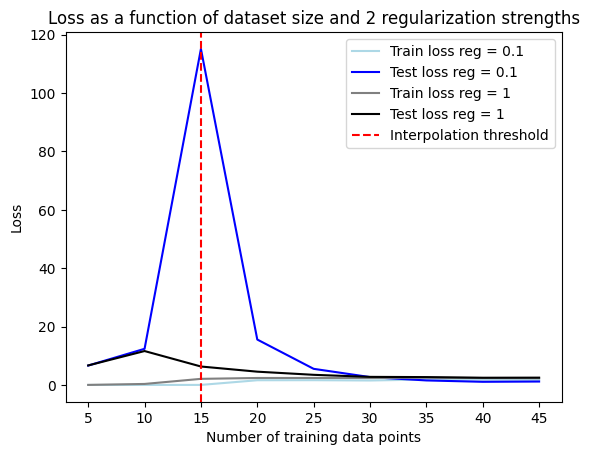

In [ ]:
# Create a figure and axis
fig, ax = plt.subplots()


ax.plot(config['n_training_data'],train_losses_regularization2[:,-1], label = "Train loss reg = 0.1", color = 'lightblue')
ax.plot(config['n_training_data'],test_losses_regularization2[:,-1], label = "Test loss reg = 0.1", color ='blue')

ax.plot(config['n_training_data'],train_losses_regularization1[:,-1], label = "Train loss reg = 1", color = 'grey')
ax.plot(config['n_training_data'],test_losses_regularization1[:,-1], label = "Test loss reg = 1", color ='black')


# Plot a vertical line at x = 5
ax.axvline(x=config['P'], color='r', linestyle='--', label = "Interpolation threshold")
ax.legend()
plt.title("Loss as a function of dataset size and 2 regularization strengths")
plt.xlabel('Number of training data points')
plt.ylabel('Loss')


**Method 3 to remove double descent: Early stopping**

The idea is to not give gradient descent enough time to fit the low singular value directions which amplify noise. Higher singular value directions are fit first (cf. many theory papers showing the spectral bias of gradient descent, one example cited below) and thus if we stop early, we won't fit the noise-amplifying lower singular value directions

Further, early stopping has been shown to formally be equivalent to ridge regression (https://proceedings.mlr.press/v89/ali19a.html)

Saxe, Andrew M., James L. McClelland, and Surya Ganguli. "Exact solutions to the nonlinear dynamics of learning in deep linear neural networks." arXiv preprint arXiv:1312.6120 (2013).

Text(0, 0.5, 'Loss')

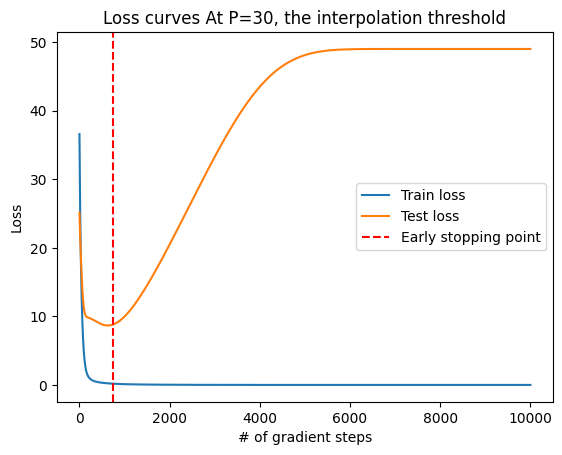

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.array(train_losses[5]),label = "Train loss");
ax.plot(np.array(test_losses[5]), label = "Test loss");
ax.axvline(x=750, color='r', linestyle='--', label = "Early stopping point")
plt.legend()
plt.title('Loss curves At P=30, the interpolation threshold')
plt.xlabel('# of gradient steps')
plt.ylabel("Loss")

Sanity check that Adam learns the same solution as closed form least squares.

In [ ]:
ans = np.linalg.pinv(X_train.numpy())@y_train.numpy()
closed_form_sol = X_train.numpy()@ans
network_output = network(X_train).detach().numpy()
print(np.sum(closed_form_sol - network_output))


0.001871367052709183


**Showing double descent while dataset size is fixed and model dimensionality varies**

In [ ]:
def load_synthetic_data(N,P,D) -> Tuple[np.ndarray, np.ndarray]:

    ## Without noise, we create model mismatch to induce double descent:
    X_bar = np.random.randn(N, P)
    X = X_bar[:, :D]
    beta_bar = np.random.randn(P, 1)
    Y = X_bar@beta_bar
    return X, Y

In [ ]:
config = {
    "learning_rate": 0.01,
    "n_grad_steps": 10000,
    "model_sizes": np.arange(5,50,5),
    "n_training_data": 20,
    "seed": 0,
}

np.random.seed(config["seed"])


model_sizes = config["model_sizes"]

train_losses = np.zeros((len(model_sizes), config["n_grad_steps"]))
test_losses = np.zeros((len(model_sizes), config["n_grad_steps"]))


for i in range(0,len(model_sizes)):

  model_size = model_sizes[i]
  X, y = load_synthetic_data(N=1000, P=1000, D=model_size)
  # Add trailing dimension to y
  if len(y.shape) == 1:
    y = y.reshape(-1, 1)

  X_train, X_test, y_train, y_test = train_test_split(
      X, y, train_size=config["n_training_data"], random_state=config["seed"]
  )

  X_train = torch.tensor(X_train).double()
  y_train = torch.tensor(y_train).double()
  X_test = torch.tensor(X_test).double()
  y_test = torch.tensor(y_test).double()


  network = linear_model(model_size)
  optimizer = torch.optim.AdamW(params = network.parameters(), lr=config["learning_rate"],betas=(0.9, 0.999), weight_decay=0.00)
  # optimizer = torch.optim.SGD(params = network.parameters(), lr=config["learning_rate"])

  for gradient_step in range(0,config["n_grad_steps"]):

      optimizer.zero_grad()

      activations = network(X_train)
      pred_minus_target = activations - y_train
      loss_train = torch.mean(torch.square(pred_minus_target))

      loss_train.backward()
      optimizer.step()
      train_losses[i, gradient_step] = loss_train.detach().numpy()

      loss_test = torch.mean(torch.square(network.forward(X=X_test) - y_test))
      test_losses[i, gradient_step] = loss_test.detach().numpy()



Text(0.5, 1.0, 'Loss as a function of model size')

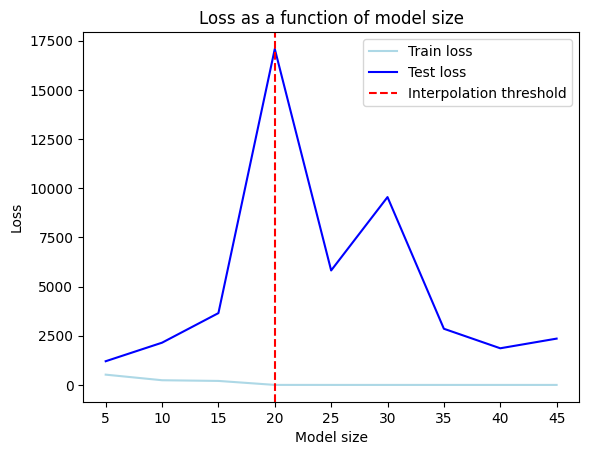

In [ ]:
# Create a figure and axis
fig, ax = plt.subplots()

ax.plot(config['model_sizes'],train_losses[:,-1], label = "Train loss",color = 'lightblue')
ax.plot(config['model_sizes'],test_losses[:,-1], label = "Test loss",color ='blue')


# Plot a vertical line at x = 5
ax.axvline(x=config['n_training_data'], color='r', linestyle='--', label = "Interpolation threshold")
ax.legend()
plt.xlabel('Model size')
plt.ylabel('Loss')
plt.title("Loss as a function of model size")